In [1]:
import pathview
import json
from pathsim.blocks import Scope
import matplotlib.pyplot as plt
import pandas as pd

# read graph data from a JSON file
with open("ARC_with_single_GLC.json", "r") as f:
    graph_data = json.load(f)

model, duration = pathview.make_pathsim_model(graph_data)

model.run(1 * 24 * 3600)


21:00:43 - INFO - LOGGING (log: True)
21:00:43 - INFO - BLOCKS (total: 36, dynamic: 10, static: 26, eventful: 1)
21:00:43 - INFO - GRAPH (nodes: 36, edges: 52, alg. depth: 6, loop depth: 0, runtime: 0.103ms)
21:00:43 - INFO - STARTING -> TRANSIENT (Duration: 86400.00s)
21:00:44 - INFO - --------------------   1% | 0.3s<16.3s | 24.7 it/s
21:00:45 - INFO - #-------------------   5% | 1.3s<19.4s | 20.2 it/s
21:00:46 - INFO - #-------------------   8% | 2.3s<26.5s | 19.3 it/s
21:00:47 - INFO - ##------------------  10% | 3.4s<43.3s | 17.8 it/s
21:00:48 - INFO - ##------------------  13% | 4.4s<44.8s | 20.1 it/s
21:00:49 - INFO - ###-----------------  16% | 5.4s<47.1s | 19.5 it/s
21:00:50 - INFO - ###-----------------  19% | 6.4s<27.4s | 22.8 it/s
21:00:50 - INFO - ####----------------  20% | 6.7s<18.5s | 21.6 it/s
21:00:51 - INFO - ####----------------  22% | 7.7s<33.1s | 21.6 it/s
21:00:52 - INFO - #####---------------  26% | 8.7s<23.2s | 23.9 it/s
21:00:53 - INFO - #####---------------  

{'total_steps': 736, 'successful_steps': 563, 'runtime_ms': 37652.380968000216}

Available scopes:
0: 16
1: 30
2: 15
OFCScope labels: ['blanket (inv)', 'HX (inv)', 'FW (inv)', 'Divertor (inv)', 'T seperation membrane (inv)']
IFCScope labels: ['storage (inv)', 'pump (inv)', 'fuel cleanup (inv)', 'ISS (inv)']


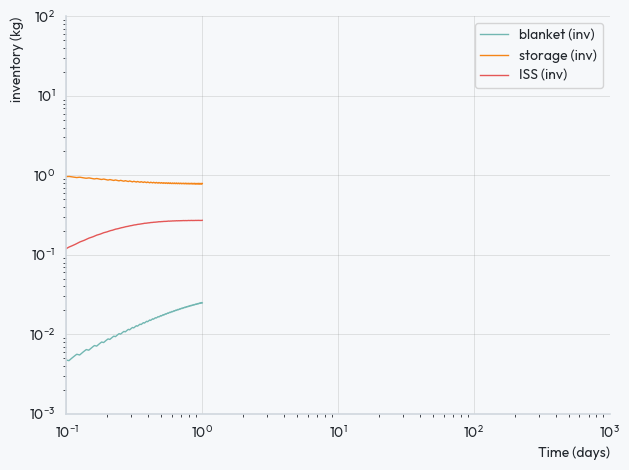

In [3]:
import morethemes as mt
mt.set_theme("lighter")

scopes = [block for block in model.blocks if isinstance(block, Scope)]

print("Available scopes:")
for i, scope in enumerate(scopes):
    print(f"{i}: {scope.id}")

ifc_scope = scopes[0]
ofc_scope = scopes[2]
fusion_rate_scope = scopes[1]

print("OFCScope labels:", ofc_scope.labels)
print("IFCScope labels:", ifc_scope.labels)

for scope in [ofc_scope, ifc_scope]:
    sim_time, data = scope.read()
    for p, d in enumerate(data):
        lb = scope.labels[p] if p < len(scope.labels) else f"port {p}"
        if any([kw in lb.lower() for kw in ["blanket", "tes", "iss", "storage"]]):
            l, = plt.plot(sim_time / 3600 / 24, d, label=lb, linewidth=1)

            if "storage" in lb.lower():
                storage_colour = l.get_color()
            elif "blanket" in lb.lower():
                blanket_colour = l.get_color()

    plt.xlabel("Time (days)")
    plt.ylabel("inventory (kg)")
    plt.yscale("log")
    plt.xscale("log")
plt.ylim(1e-3, 1e2)
plt.xlim(1e-1, 1e3)

plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("arc_with_single_GLC.pdf")
